In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Q5

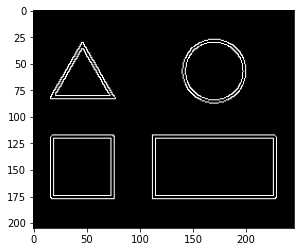

In [3]:
shapes = plt.imread("images/Q7.png")
shapes_gray = np.dot(shapes[...,:3], [0.299, 0.587, 0.114]) # by searching. for converting to grayscale
shape_edges = cv2.Canny(np.uint8(shapes_gray * 255), 50, 150) # Canny Edge Detection
treshold = 50
# ret, shape_edges = cv2.threshold(shapes_gray*255, treshold, 255, cv2.THRESH_BINARY)
plt.imshow(shape_edges, cmap="gray")

4


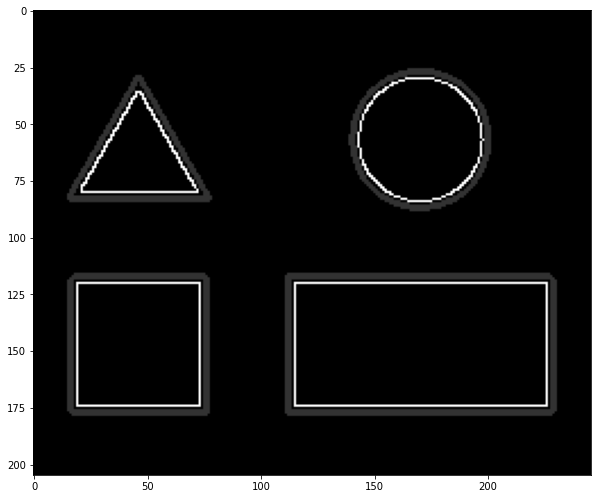

In [4]:
contours_output = shape_edges.copy()
contours, hierarchy = cv2.findContours(shape_edges//255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# I set cv2.RETR_EXTERNAL so that shapes that are in another shape won't be considered as a shape
print(len(contours))
for i in range(len(contours)):
    for j in range(len(contours[i])):
        x, y = contours[i][j][0][0], contours[i][j][0][1]
        cv2.circle(shape_edges, (x,y), radius=1, color=50, thickness=-1)
plt.figure(figsize=(10,10))
plt.imshow(shape_edges, cmap="gray")

In [5]:
def binary2rgb(bin_img):
    rgb_image = np.zeros((bin_img.shape[0], bin_img.shape[1], 3), dtype=np.uint8)
    rgb_image[bin_img == 255] = (255,255,255)
    return rgb_image

In [6]:
def draw_contour(rgb_img, contours):
    approximates = []
    for cnt in contours:
        # indicates how much accurate approxPolyDP works. to be precise, it is the maximum distance between
        # original contour and approximated one. sum of distances between consecutive points on a shape indicates
        # the perimeter of that shape. this sum of distances between consecutive points in the approximated contour
        # is different since it reduces number of points. epsilon specifies the maximum difference of this perimeter 
        # value in original one and approximated one
        epsilon = 0.03 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        approximates.append(approx)
        print(len(approx))
        cv2.drawContours(rgb_img, [approx], 0, (255, 0, 0), 2)
    return rgb_img, approximates

4
4
3
8
4


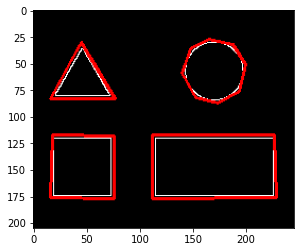

In [7]:
rgb = binary2rgb(shape_edges)
result, approximates = draw_contour(rgb, contours)
print(len(approximates))
plt.imshow(result)

In [8]:
def classify_shapes(approximates):
    result = []
    for approx in approximates:
        vertice_cnt = len(approx)
        if vertice_cnt == 3:
            shape = "triangle"
        elif vertice_cnt == 4:
            # this function takes a set of points and returns the cooridinates of the smallest rectangle
            # that covers these points
            x, y, w, h = cv2.boundingRect(approx)
            w2h_ratio = float(w)/h
            if w2h_ratio >= 0.95 and w2h_ratio <= 1.05:
                shape = "square"
            else:
                shape = "rectangle"
        else:
            shape = "circle"
        x,y,w,h = cv2.boundingRect(approx)
        result.append((x,y,shape))
    return result

In [9]:
result = classify_shapes(approximates)
for item in result:
  x,y,shape = item[0], item[1], item[2]
  cv2.putText(shapes, shape, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
# plt.imshow(shapes)
cv2.imshow('shapes', shapes)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Q2 Fourier

In [10]:
saffrun = cv2.imread("images/saffrun.jpg", cv2.IMREAD_GRAYSCALE)

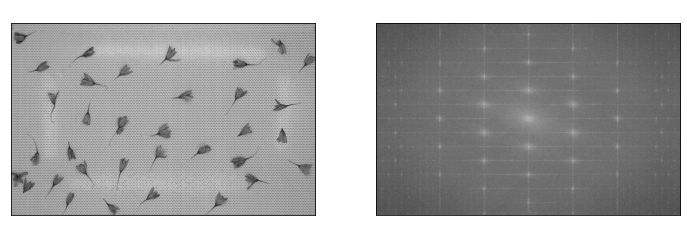

In [11]:
f = np.fft.fft2(saffrun)
fshift = np.fft.fftshift(f)
# this is for improving contrast to see the details in the image of fft
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.figure(figsize=(12,12))
plt.subplot(121),plt.imshow(saffrun, cmap = 'gray')
plt.title('Input Image', color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum', color="white"), plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
# define gaussian kernel
# the kernel should be the same size with original image to be multiplied with frequency domain
kernel_x, kernel_y = saffrun.shape[0], saffrun.shape[1]
sigma = 30
kernel = np.zeros((kernel_x, kernel_y))
for i in range(kernel_x):
    for j in range(kernel_y):
        kernel[i,j] = np.exp(-((i - kernel_x // 2)**2 + (j - kernel_y // 2)**2) / (2 * sigma**2))
# Normalize the kernel
kernel = kernel / np.sum(kernel)

In [13]:
# multiplying fshift with kernel to remove some high frequencies
modified_freq_shift = np.multiply(fshift, kernel)
# now we should shift back this modified fourier so that we can reach back to our image in space domain
modified_freq = np.fft.ifftshift(modified_freq_shift)
# back to space domain using ifft2
filtered_img = np.fft.ifft2(modified_freq)
# result image data of ifft2 are complex type, we should get the real part
filtered_img = np.real(filtered_img)
# Normalizing the output
filtered_img = filtered_img / np.max(filtered_img)

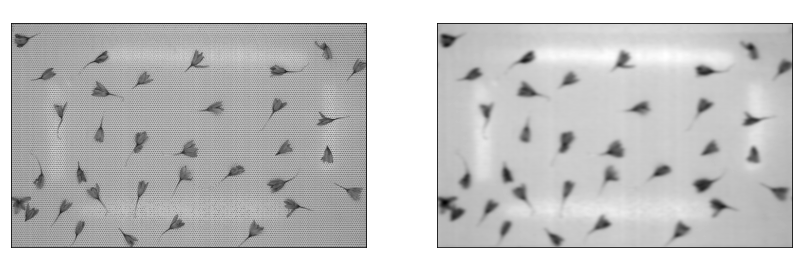

In [14]:
plt.figure(figsize=(14,14))
plt.subplot(121),plt.imshow(saffrun, cmap = 'gray')
plt.title('Input Image', color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(filtered_img, cmap = 'gray')
plt.title('filtered image', color="white"), plt.xticks([]), plt.yticks([])
plt.show()

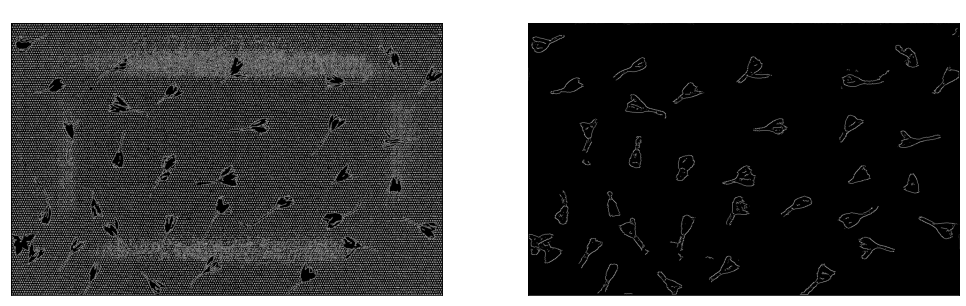

In [15]:
edges1 = cv2.Canny(np.uint8(saffrun), 100, 200) # Canny Edge Detection
# Canny Edge Detection
# we should cast filtered image data to uint8 because that's what canny function expects,
# also it should be multiplied by 255 to be in range 0 to 255
edges = cv2.Canny(np.uint8(filtered_img * 255), 100, 200, apertureSize=5) # apertureSize parameter indicates the size of sobel kernel used for calculating gradient. the more the apertureSize, the smoother the image. this worked for me with apertureSize=5 and didn't work with default value which is 3
# Display Canny Edge Detection Image
plt.figure(figsize=(17,17))
plt.subplot(121),plt.imshow(edges1, cmap = 'gray')
plt.title('Canny Edge Detection before canceling noise by fourier transform', color="white"), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges, cmap = 'gray')
plt.title('Canny Edge Detection after canceling noise by fourier transform', color="white"), plt.xticks([]), plt.yticks([])
plt.show()
# cv2.imshow('Canny Edge Detection before canceling noise by fourier transform', edges1)
# cv2.waitKey(0)
# cv2.imshow('Canny Edge Detection after canceling noise by fourier transform', edges)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

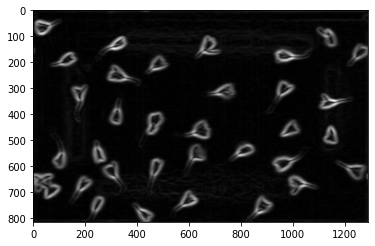

In [20]:
sobel_x = np.array([[-1,0,1], [-2,0,2], [-1,0,1]], dtype=np.int32)
sobel_y = np.array([[-1,-2,-1], [0,0,0], [1,2,1]], dtype=np.int32)
gx = cv2.filter2D(filtered_img, ddepth=-1, kernel=sobel_x)
gy = cv2.filter2D(filtered_img, ddepth=-1, kernel=sobel_y)
mag = np.sqrt(gx**2 + gy**2)
dirs = np.arctan2(gy, gx)
plt.imshow(mag, cmap="gray")